Jako model sieciu użyto modelu z artykułu https://arxiv.org/abs/2009.11212

Wyjaśnienie batch_size https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network

In [152]:
!pwd
!ls
!ls ../../../SpinakerV1Data/2023-01-27-d3-red

/tf/SpinakerV1/assets/jupyter
__pycache__  model1.ipynb
data.csv  img


In [153]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.python.keras.models import load_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import cv2
import pandas as pd
import ntpath
import random
import tensorflow as tf

tf.random.set_seed(42)
print(keras.__version__)
print(tf.__version__)

%matplotlib inline

2.11.0
2.11.0


In [209]:
datadir = '../../../SpinakerV1Data/2023-01-27-d3-red'
data = pd.read_csv(os.path.join(datadir, 'data.csv'))
pd.set_option('display.max_colwidth', None)
data.head()
print(data)

          filename    v  omega
0     img/0000.jpg  0.4 -0.625
1     img/0001.jpg  0.4 -0.550
2     img/0002.jpg  0.4 -0.450
3     img/0003.jpg  0.4 -0.400
4     img/0004.jpg  0.4 -0.350
...            ...  ...    ...
3585  img/3585.jpg  0.4  0.325
3586  img/3586.jpg  0.4  0.300
3587  img/3587.jpg  0.4  0.275
3588  img/3588.jpg  0.4  0.250
3589  img/3589.jpg  0.4  0.225

[3590 rows x 3 columns]


[-6.9000001 -6.6225001 -6.3450001 -6.0675001 -5.7900001 -5.5125001
 -5.2350001 -4.9575001 -4.6800001 -4.4025001 -4.1250001 -3.8475001
 -3.5700001 -3.2925001 -3.0150001 -2.7375001 -2.4600001 -2.1825001
 -1.9050001 -1.6275001 -1.3500001 -1.0725001 -0.7950001 -0.5175001
 -0.2400001  0.0374999  0.3149999  0.5924999  0.8699999  1.1474999
  1.4249999  1.7024999  1.9799999  2.2574999  2.5349999  2.8124999
  3.0899999  3.3674999  3.6449999  3.9224999  4.1999999  4.4774999
  4.7549999  5.0324999  5.3099999  5.5874999  5.8649999  6.1424999
  6.4199999  6.6974999  6.9749999]
[-6.7612501 -6.4837501 -6.2062501 -5.9287501 -5.6512501 -5.3737501
 -5.0962501 -4.8187501 -4.5412501 -4.2637501 -3.9862501 -3.7087501
 -3.4312501 -3.1537501 -2.8762501 -2.5987501 -2.3212501 -2.0437501
 -1.7662501 -1.4887501 -1.2112501 -0.9337501 -0.6562501 -0.3787501
 -0.1012501  0.1762499  0.4537499  0.7312499  1.0087499  1.2862499
  1.5637499  1.8412499  2.1187499  2.3962499  2.6737499  2.9512499
  3.2287499  3.5062499  3.7

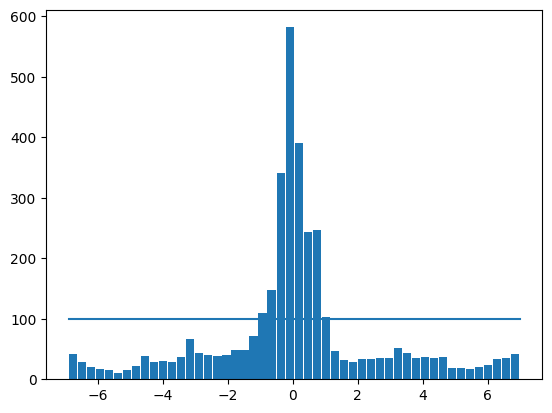

In [211]:
num_bins = 50
samples_per_bin = 100
hist, bins = np.histogram(data['omega'], num_bins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center, hist, width=0.25)
plt.plot((np.min(data['omega']), np.max(data['omega'])), (samples_per_bin, samples_per_bin))
print(bins)
print(center)

total date: 3590
removed  1365
remaning 2225


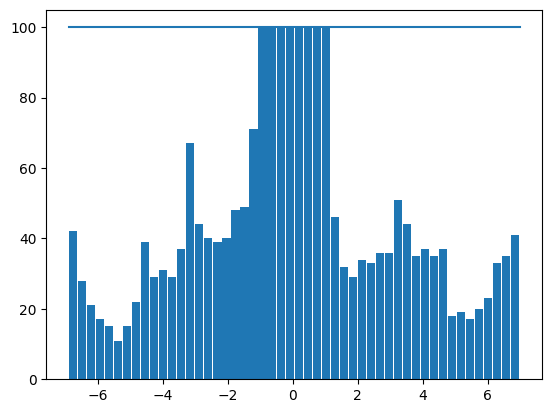

In [212]:
print('total date:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['omega'])):
    if data['omega'][i] >= bins[j] and data['omega'][i] <= bins[j+1]:
      list_.append(i) 
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaning', len(data))

hist, _ = np.histogram(data['omega'], num_bins)
plt.bar(center, hist, width=0.25)
plt.plot((np.min(data['omega']), np.max(data['omega'])), (samples_per_bin, samples_per_bin))

In [166]:
print(data.iloc[1])
def load_img_stearing(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        # Save path to image
        image_path.append(os.path.join(datadir, data.iloc[i].filename.strip()))
        # Save omega 
        steering.append(float( data.iloc[i].omega ))

    image_paths = np.array(image_path)
    steerings = np.array(steering)
    return image_paths, steerings                                           

image_paths, steerings = load_img_stearing(datadir, data)

filename    img/0001.jpg
v                    0.4
omega              -0.55
Name: 1, dtype: object


In [167]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Traning Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
print(X_train[1])
print(y_train[1])

Traning Samples: 1780
Valid Samples: 445
../../../SpinakerV1Data/2023-01-27-d3-red/img/1149.jpg
6.925000190734863


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '0.996078431372549 0.09803921568627451')

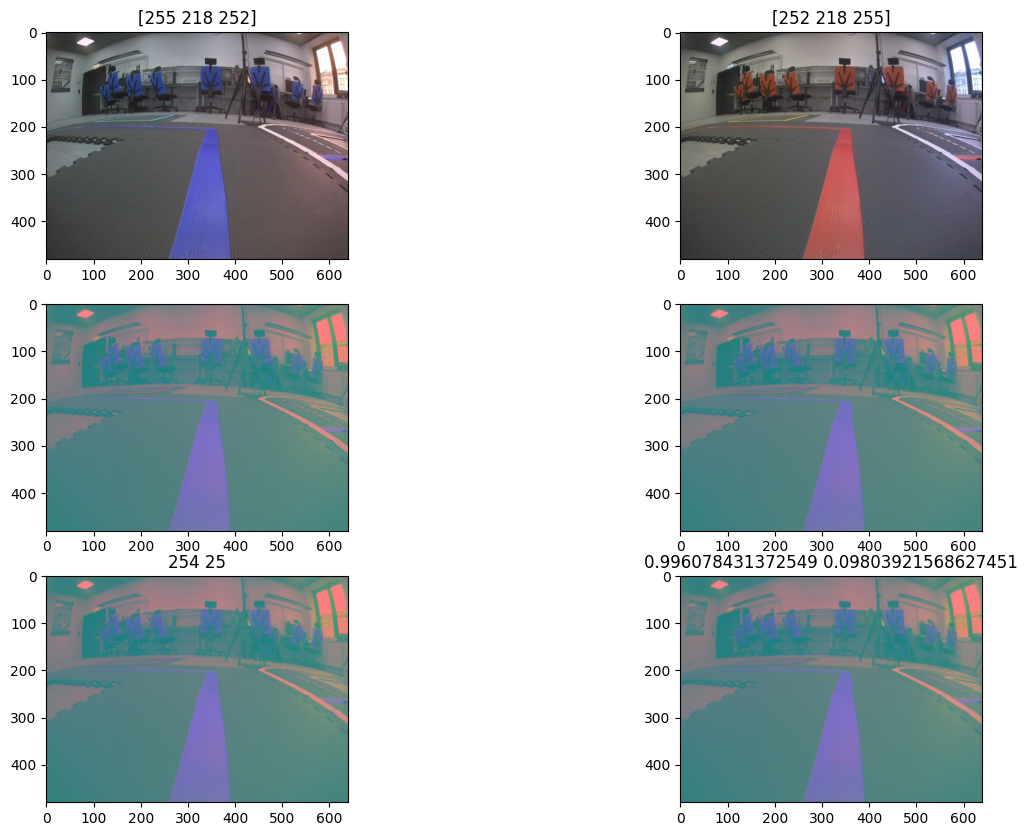

In [168]:
fig, axes = plt.subplots(3, 2, figsize=(15,10))
imgo = cv2.imread(image_paths[100], cv2.IMREAD_COLOR)
axes[0,0].set_title(imgo[0,0,:])
axes[0,0].imshow(imgo)
axes[0,0].axis('on')

imgc = cv2.cvtColor(imgo, cv2.COLOR_BGR2RGB)
axes[0,1].set_title(imgc[0,0,:])
axes[0,1].imshow(imgc)
axes[0,1].axis('on')

axes[1,0].imshow(cv2.cvtColor( imgo, cv2.COLOR_BGR2YUV))
axes[1,1].imshow(cv2.cvtColor( imgc, cv2.COLOR_RGB2YUV))

imagecg = cv2.GaussianBlur(cv2.cvtColor( imgo, cv2.COLOR_BGR2YUV), (3, 3), 0)
axes[2,0].imshow( imagecg )
axes[2,0].set_title("{} {}".format(np.max(imagecg), np.min(imagecg)))
imgecg_n = (imagecg - np.min(imagecg)) / (np.max(imagecg) - np.min(imagecg))
imgecg_n = imagecg/255.0
axes[2,1].imshow( imgecg_n )
axes[2,1].set_title("{} {}".format(np.max(imgecg_n), np.min(imgecg_n)))


Text(0.5, 1.0, 'Validations sets')

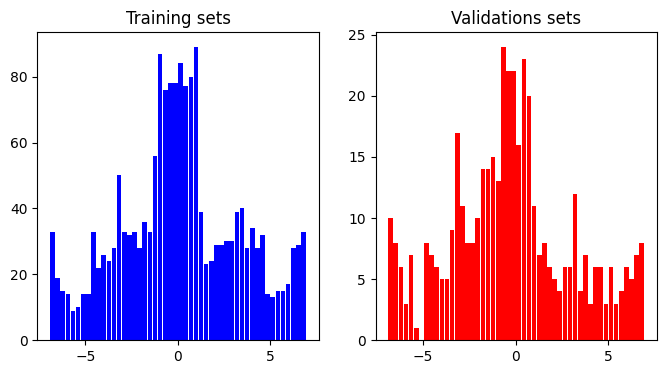

In [169]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].hist(y_train, bins=num_bins, width=0.25, color='blue')
axes[0].set_title('Training sets')
axes[1].hist(y_valid, bins=num_bins, width=0.25, color='red')
axes[1].set_title('Validations sets')

In [170]:
def img_preprocess(img_path):
    img = cv2.imread(img_path)
    img = img[300:500, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (80, 60))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

(-0.5, 79.5, 59.5, -0.5)

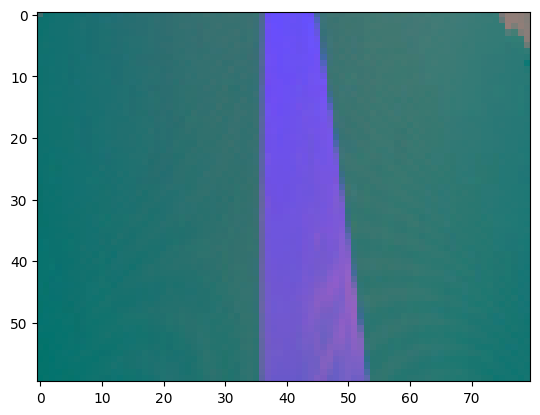

In [171]:
plt.imshow(img_preprocess(image_paths[random.randint(0, len(X_train)-1)]))
plt.axis('on')

Convert X_train with image paths to image as np.array

In [172]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(1780, 60, 80, 3)


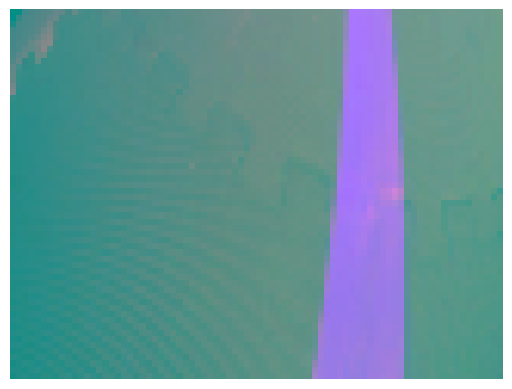

In [173]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)] )
plt.axis('off')
print(X_train.shape)

In [196]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), input_shape=(60,80,3),activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D((2,2)))

    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1))

    optimizer= Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)

    return model

model=nvidia_model()
print(model.summary())

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_185 (Conv2D)         (None, 58, 78, 32)        896       
                                                                 
 max_pooling2d_153 (MaxPooli  (None, 29, 39, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_186 (Conv2D)         (None, 27, 37, 32)        9248      
                                                                 
 max_pooling2d_154 (MaxPooli  (None, 13, 18, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_187 (Conv2D)         (None, 11, 16, 64)        18496     
                                                                 
 max_pooling2d_155 (MaxPooli  (None, 5, 8, 64)       

In [206]:
tf.random.set_seed(42)
model=nvidia_model()
history = model.fit(X_train, y_train, 
    epochs=10, 
    validation_data=(X_valid, y_valid), 
    batch_size=75, 
    verbose=1, shuffle=1)

Epoch 1/10
24/24 [==============================] - 1s 12ms/step - loss: 4.9460 - val_loss: 1.3106
Epoch 2/10
24/24 [==============================] - 0s 5ms/step - loss: 1.0370 - val_loss: 0.3955
Epoch 3/10
24/24 [==============================] - 0s 5ms/step - loss: 0.5157 - val_loss: 0.1222
Epoch 4/10
24/24 [==============================] - 0s 5ms/step - loss: 0.3452 - val_loss: 0.0728
Epoch 5/10
24/24 [==============================] - 0s 5ms/step - loss: 0.3207 - val_loss: 0.0696
Epoch 6/10
24/24 [==============================] - 0s 5ms/step - loss: 0.3064 - val_loss: 0.0621
Epoch 7/10
24/24 [==============================] - 0s 5ms/step - loss: 0.2459 - val_loss: 0.0407
Epoch 8/10
24/24 [==============================] - 0s 5ms/step - loss: 0.2335 - val_loss: 0.0395
Epoch 9/10
24/24 [==============================] - 0s 5ms/step - loss: 0.2776 - val_loss: 0.0445
Epoch 10/10
24/24 [==============================] - 0s 5ms/step - loss: 0.2250 - val_loss: 0.1184


Text(0.5, 0, 'Epoch')

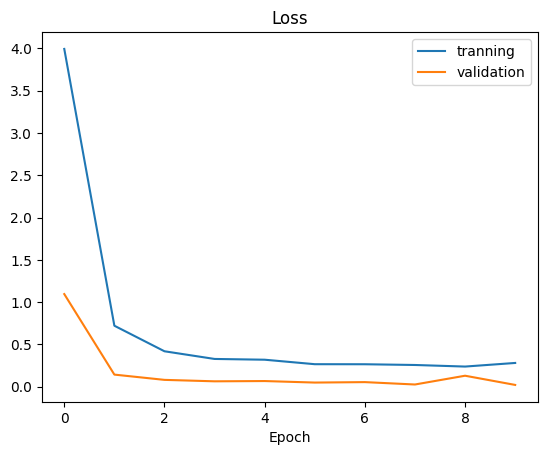

In [198]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['tranning', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

* model-2022-01-25-01.h5 - z normalizacja
* model-2022-01-25-02.h5 - bez normalizacji 

In [207]:
nn_model_path = '../../../SpinakerV1/assets/nn_models/'
nn_model_name = 'model-v1.h5'
model.save(nn_model_path + nn_model_name)

# Walidacja modelu

In [178]:
model2 = load_model(nn_model_path + nn_model_name)
model2.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_170 (Conv2D)          (None, 58, 78, 32)        896       
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 56, 76, 32)        9248      
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 26, 36, 64)        18496     
_________________________________________________________________
max_pooling2d_142 (MaxPoolin (None, 13, 18, 64)        0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 13, 18, 64)        0         
_________________________________________________________________
flatten_56 (Flatten)         (None, 14976)           

img_index: 1067, ../../../SpinakerV1Data/2023-01-27-d3-red/img/1760.jpg => steering: 3.275000095367432
NN model result steering: 3.1142101287841797
Difference between data and model prediction: 0.1607899665832524


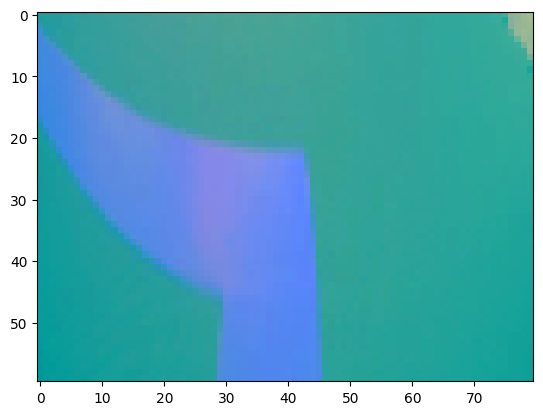

In [191]:
img_index = random.randint(0, len(X_train)-1)
prepared_image = np.array(img_preprocess(image_paths[img_index]))
plt.imshow(cv2.imread(image_paths[img_index], cv2.IMREAD_COLOR))
plt.imshow(prepared_image, aspect="auto")
model2_result = model2.predict_on_batch( np.expand_dims(prepared_image, 0))

print("img_index: {}, {} => steering: {}".format(img_index, image_paths[img_index], steerings[img_index]) )
print("NN model result steering: {}".format(model2_result[0,0]))
print("Difference between data and model prediction: {}".format(steerings[img_index]-model2_result[0,0]))